In [8]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
#import matplotlib, copy, skimage, os, tifffile
from skimage import io, morphology, draw
import gdal
from PIL import Image
import random
import json
from tqdm import tqdm
import io
import glob
import shutil
import os
import geopandas as gpd

In [9]:
# modified to buffer the bounding boxes by 15 pixels
# return uids of bboxes as well 
# this is for geojson with 2 classes: damaged and non-damaged
def get_labels_w_uid_nondamaged(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
      # debug
    x_off = 15
    y_off = 15
    right_shift = 5  # how much shift to the right 
    add_np = np.array([-x_off + right_shift, -y_off, x_off + right_shift, y_off])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    # debug
    uids = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['id']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
                # debug
                uids[i] = int(data['features'][i]['properties']['bb_uid'])
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes, uids

In [10]:
# modified to buffer the bounding boxes by 15 pixels
# return uids of bboxes as well 
def get_labels_w_uid(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
      # debug
    x_off = 15
    y_off = 15
    right_shift = 5  # how much shift to the right 
    add_np = np.array([-x_off + right_shift, -y_off, x_off + right_shift, y_off])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    # debug
    uids = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['IMAGE_ID']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
                # debug
                uids[i] = int(data['features'][i]['properties']['bb_uid'])
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes, uids

In [11]:
fname = '../just_buildings_w_uid.geojson'
#fname = '../added_non_damaged_cleaned.geojson'
coords, chips, classes, uids = get_labels_w_uid(fname)

100%|██████████| 11093/11093 [00:00<00:00, 140758.85it/s]


In [12]:
# draw boxs that specify index number on each bboxes

import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# draw bboxes with bbox uid

def draw_bboxes_withindex(img,boxes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 40)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        draw.text((xmin-70, ymin-20), str(uids[idx]), font = font, fill = "orange")
        idx +=1
    return source



In [15]:
# draw boxs that specify index number on each bboxes

import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# draw bboxes with bbox uid

def draw_bboxes_withindex_multiclass(img,boxes,classes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 40)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        if classes[idx] == 1: 
        
            for j in range(3):
                draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        else:
            for j in range(3):
                draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="green")
        draw.text((xmin+70, ymin+20), str(uids[idx]), font = font, fill = "orange")
        idx +=1
    return source



/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170901_1030010070C13600_3030230_jpeg_compressed_02_07.tif


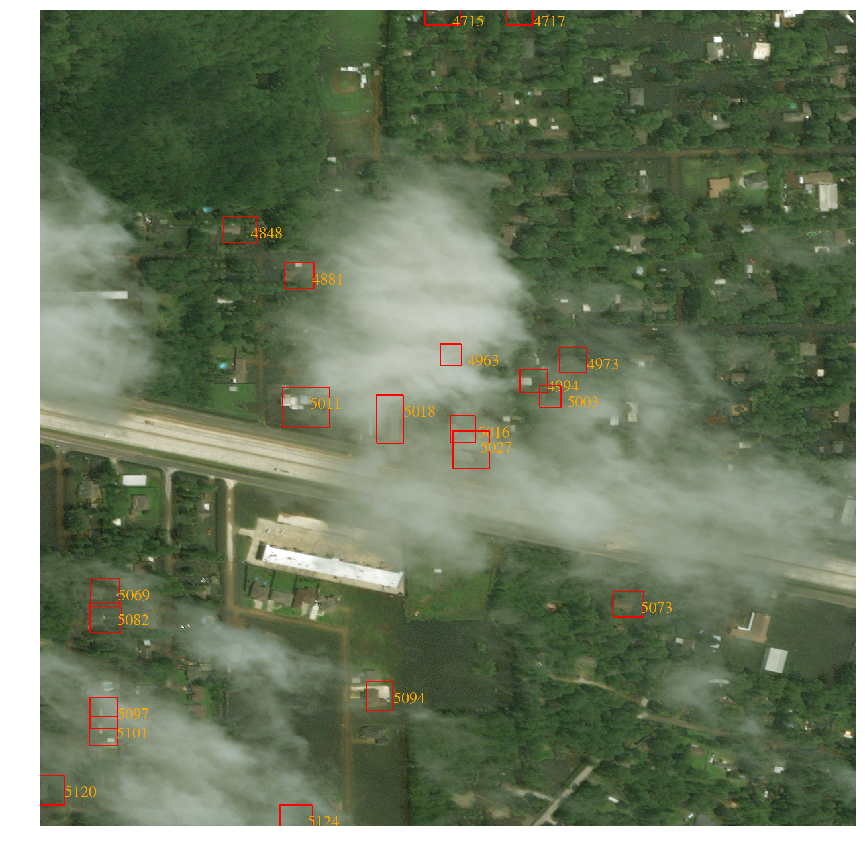

In [16]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'

#chip_name = '20170902_105001000B9D7F00_3030321_jpeg_compressed_07_03.tif'
#chip_name = '20170902_105001000B9D7E00_3030211_jpeg_compressed_07_09.tif'
chip_name = '20170901_1030010070C13600_3030230_jpeg_compressed_02_07.tif'

chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
# print(coords_chip)

# add offsets
# x_off = 15
# y_off = 15
# add_np = np.array([-x_off, -y_off, x_off, y_off])
# coords_chip = np.add(coords_chip, add_np)

# CAUTION: should check the wether the shifted bboxes are within big image boundary

classes_chip = classes[chips==chip_name].astype(np.int64)
uids_chip = uids[chips == chip_name].astype(np.int64)
#labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
labelled = draw_bboxes_withindex_multiclass(arr,coords_chip,classes_chip, uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [17]:
# delete bboxes based on bbox uid
# return new geojson
# fname = '../just_buildings_w_uid.geojson'
def delete_bbox_from_geojson(old_geojson, rows_to_delete):
    gfN = gpd.read_file(old_geojson)
    index_list = []
    df_len = len(gfN)
    

    for i in range(0, df_len):
        print('idx', i)
        series_tmp = gfN.loc[i]
        if series_tmp['bb_uid'] in set(rows_to_delete):
            continue
        index_list.append(i)
    geometries = [xy for xy in list(gfN.iloc[index_list]['geometry'])]
    crs = {'init': 'epsg:4326'}
    gf = gpd.GeoDataFrame(gfN.iloc[index_list], crs=crs, geometry=geometries)

# geometries = [shapely.geometry.Point(xy) for xy in zip(df.lng, df.lat)]
# gf = gpd.GeoDataFrame(gfN.iloc[0],)
    parent_folder = os.path.abspath(old_geojson + "/../")

    # get training or test dir name
    f_base = os.path.basename(old_geojson)
    
    save_name = ''.join(f_base.split('.')[0:-1]) +'_cleaned.geojson'
    print(save_name)
    gf.to_file(parent_folder+'/'+ save_name, driver='GeoJSON')
     
 

In [18]:
# rows_to_delete = [8591, 978]
# delete_bbox_from_geojson(fname, rows_to_delete)

In [19]:
# load new geojosn

new_geojson = fname = '../just_buildings_w_uid_cleaned.geojson'
coords, chips, classes, uids = get_labels_w_uid(fname)

100%|██████████| 10866/10866 [00:00<00:00, 142614.03it/s]


/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif


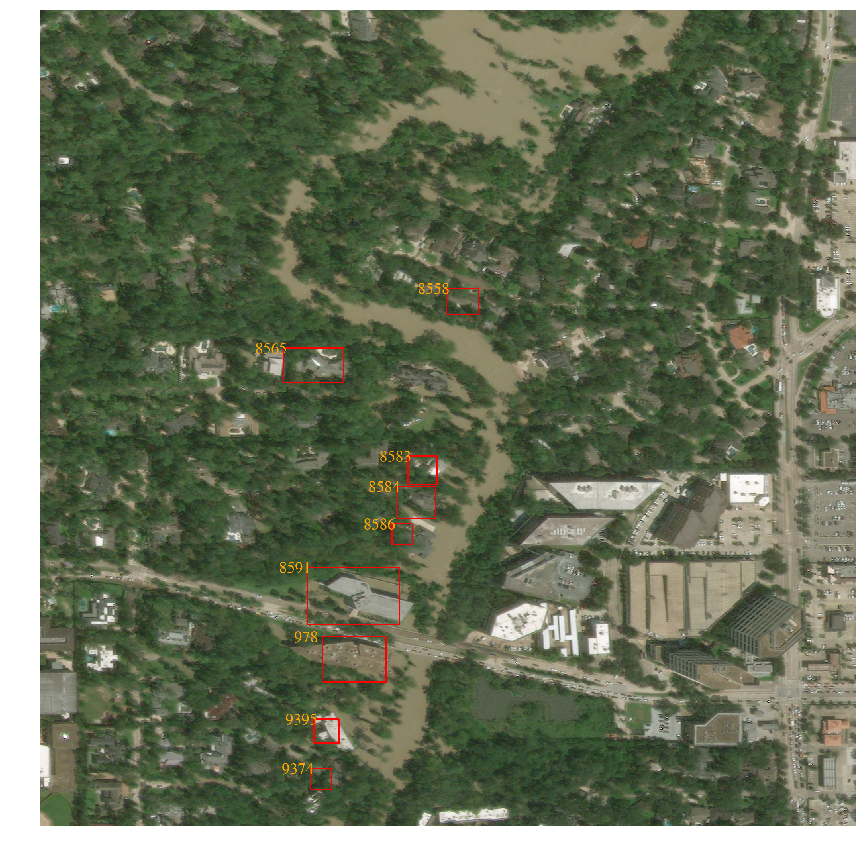

In [20]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'
chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
# print(coords_chip)

# add offsets
# x_off = 15
# y_off = 15
# add_np = np.array([-x_off, -y_off, x_off, y_off])
# coords_chip = np.add(coords_chip, add_np)

# CAUTION: should check the wether the shifted bboxes are within big image boundary

classes_chip = classes[chips==chip_name].astype(np.int64)
uids_chip = uids[chips == chip_name].astype(np.int64)
#labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
labelled = draw_bboxes_withindex(arr,coords_chip[classes_chip ==1],uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [61]:
# # delete bboxes based on bbox id
# # i.e.: {chip_name : [0, 2, 3]}
# # return new bbox and its class


# def delete_bbox(img, boxes, classes, chip_name, rows_to_delete):
    
#     if len(rows_to_delete) == 0:
#         return img,  boxes, classes
#     else:
#         # return boxes and classes with clouds removed
#         new_coords = np.delete(boxes, rows_to_delete, axis=0)
#         new_classes = np.delete(classes, rows_to_delete, axis=0)
#         return img, new_coords, new_classes

    





In [84]:
# test
rows_to_delete = [8591, 978]

img, new_coords, new_classes = delete_bbox(arr, coords_chip[classes_chip ==1], classes_chip[classes_chip==1], chip_name, rows_to_delete)

labelled_2 = draw_bboxes_withindex(img, new_coords)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled_2)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


TypeError: draw_bboxes_withindex() missing 1 required positional argument: 'uids'

In [43]:
# take absolut path of chip files
# converted to png files

def draw_bbox_on_tiff(chip_path, coords, chips, classes, save_path):
    #Load an image
    #path = '/home/ubuntu/anyan/harvey_data/converted_sample_tiff/'
    
    
    # big tiff name: chip name
    # init to {big_tiff_name : []}
    #big_tiff_dict = dict((k, []) for k in big_tiff_set)

    fnames = glob.glob(chip_path + "*.tif")
    i = 0
    for f in fnames:
        
        chip_name = f.split('/')[-1]
        chip_big_tiff_id_list = chip_name.split('_')[1:3]
        chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
        print(chip_big_tiff_id)
        #if chip_big_tiff_id not in set(big_tiff_dict.keys()):
         #   big_tiff_dict[chip_big_tiff_id] = list()
          #  big_tiff_dict[chip_big_tiff_id].append(chip_name)
        #else:
            
#         if len(big_tiff_dict[chip_big_tiff_id]) < 5:


           #big_tiff_dict[chip_big_tiff_id].append(chip_name)
        arr = wv.get_image(f)
#             print(arr.shape)
    #         plt.figure(figsize=(10,10))
    #         plt.axis('off')
    #         plt.imshow(arr)
        coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
        if coords_chip.shape[0] == 0:
            print('no bounding boxes for this image')
            continue
        classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
        labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
        print(chip_name)
#             plt.figure(figsize=(15,15))
#             plt.axis('off')
#             plt.imshow(labelled)
        subdir_name = save_path + chip_big_tiff_id
        if os.path.isdir(subdir_name):
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
        else:
            os.mkdir(subdir_name)
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
           


In [44]:
# path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'
# save_path =  '/home/ubuntu/anyan/harvey_data/bbox_debug_png/'
# draw_bbox_on_tiff(path, coords, chips, classes, save_path)

In [45]:
# coords = coords[chips==chip_name]
# classes = classes[chips==chip_name].astype(np.int64)

In [47]:
print(classes)

[1. 1. 1. ... 2. 2. 2.]


[[ 703. 1571.  862. 1685.]
 [1013.  697. 1094.  762.]
 [ 605.  847.  756.  934.]
 [ 917. 1118.  990. 1190.]
 [ 889. 1194.  986. 1275.]
 [ 877. 1288.  928. 1339.]
 [ 665. 1397.  896. 1541.]
 [ 672. 1902.  725. 1954.]
 [ 681. 1778.  744. 1838.]]
[1 1 1 1 1 1 1 1 1]


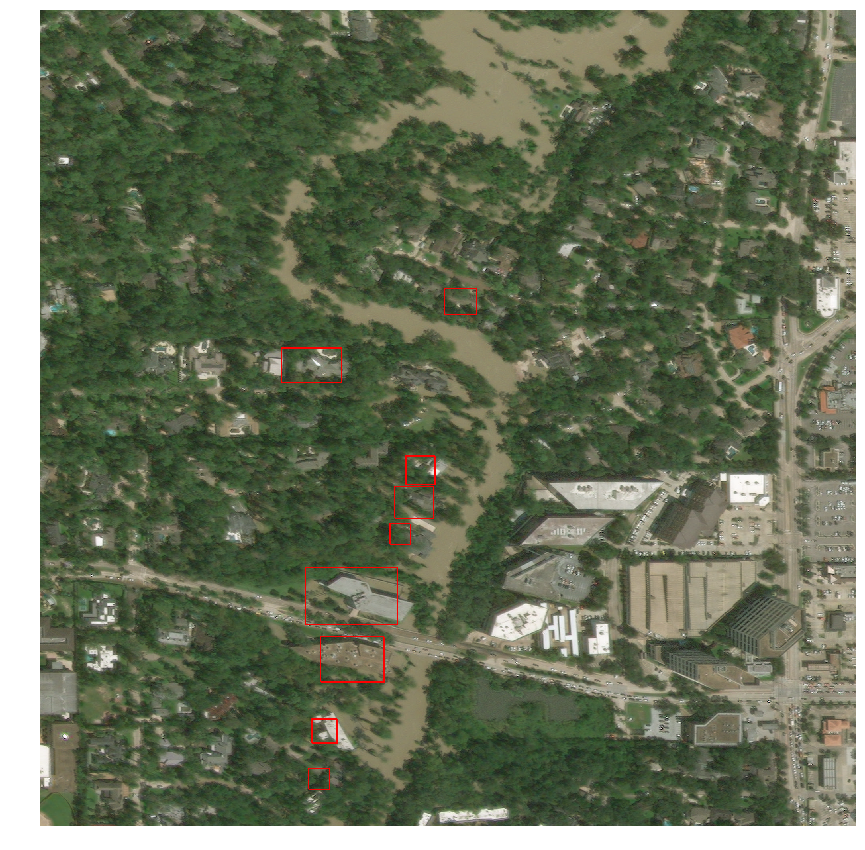

In [48]:
coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
print(coords_chip)
classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
print(classes_chip)
labelled = aug.draw_bboxes(arr,coords_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

In [49]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords_chip, classes=classes_chip, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 16


In [50]:
len(c_box[2])

1

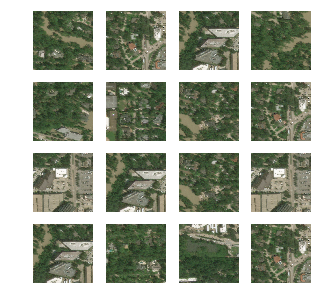

In [51]:
#We can plot some of the chips
fig,ax = plt.subplots(4)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

In [52]:
# detect black blocks in an image
# take an img in array format
# determine whether the area of the black portion is larger than a threshold: 0.1
# return True if the img contain large portions of black 


def detect_blackblock(img):
    # check the # of pixels that with RGB values are all equal to 0
    w,h,c = img.shape
    black_pixel_count=0
    threshold = 0.1 * w * h
    
    for i in range(w):
        for j in range(h):
#             print()
            #if img[i,j,0]== 0 and img[i,j,1]== 0 and img[i,j,2]== 0:
            if np.all(img[i,j,:] ==0):
                black_pixel_count+=1
                if black_pixel_count > threshold:
                    return True
    return False
                

    

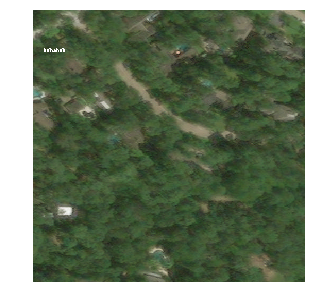

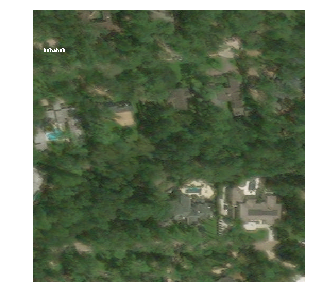

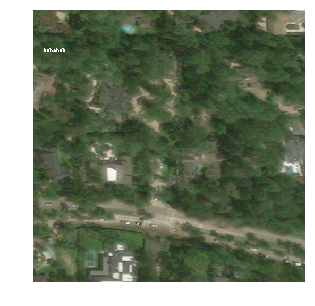

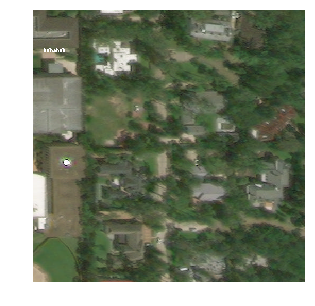

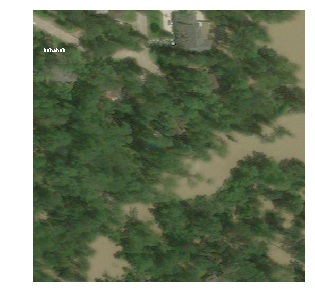

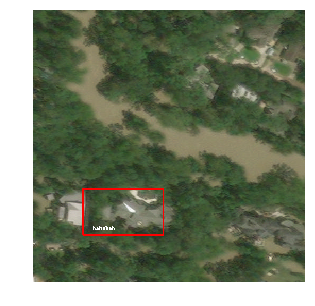

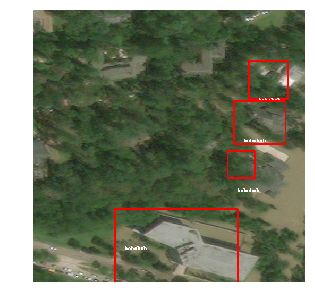

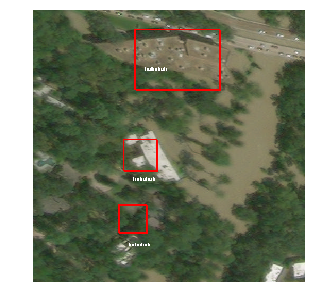

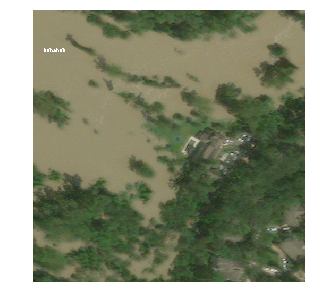

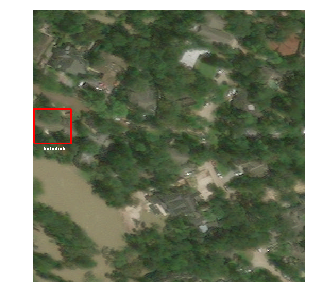

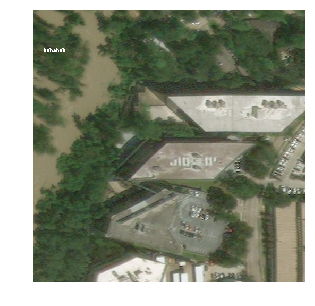

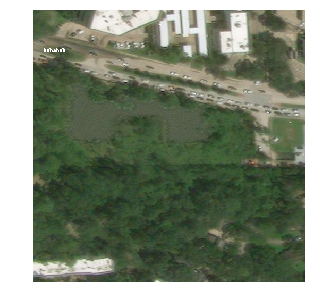

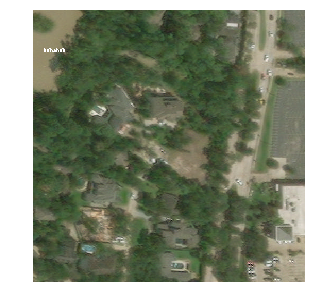

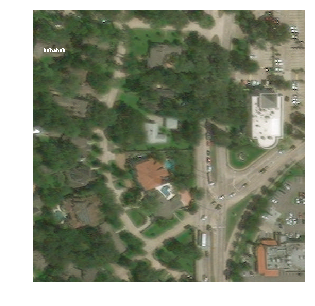

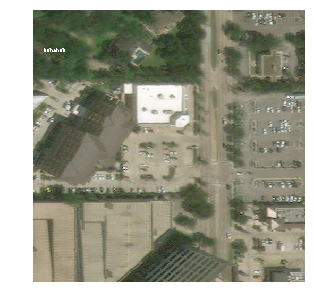

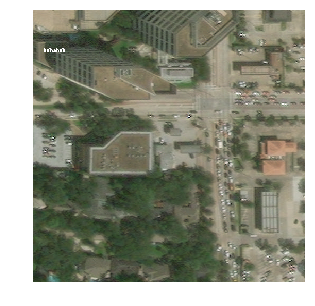

In [54]:
#We can visualize the chips with their labels
for ind in range(0, c_img.shape[0]):
    #ind = np.random.choice(range(c_img.shape[0]))
#     if detect_blackblock(c_img[ind]): # contain black, ignore
#         continue
    #labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
    labelled = draw_bboxes_withindex(c_img[ind],c_box[ind])
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(labelled)

In [15]:
detect_blackblock(arr)

False

In [16]:




# labelled = aug.draw_bboxes(arr,coords[classes ==1])
# plt.figure(figsize=(15,15))
# plt.axis('off')
# plt.imshow(labelled)

In [17]:
# labelled.save("test.png")